In [1]:
from rdkit import Chem
import numpy as np
from collections import defaultdict
import sys
import pickle
import os
import re
sys.path.append('../')
sys.path.append('../data_processing/')
sys.path.append('../evaluation')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from tqdm import tqdm
import py3Dmol

In [2]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from utils_eval import build_pdb_dict, pp_match, extract_pp, extract_all_pp, group_by
from script_utils import load_qm9_data

In [4]:
# ligand_name = '3nbq_B_rec_3nbq_urf_lig_tt_docked_2'  # okay
# ligand_name = '3euf_A_rec_3nbq_urf_lig_tt_min_0'  # okay
# ligand_name = '3eue_A_rec_3nbq_urf_lig_tt_min_0'  # good, check optimized?

# ligand_name = '3p1c_B_rec_3p1f_3pf_lig_tt_min_0'  # bad

# ligand_name = '5swg_A_rec_5swt_71a_lig_tt_min_0'  # almost same

# ligand_name = '2vce_A_rec_2vce_tc7_lig_tt_docked_0'  # okay
# ligand_name = '2vce_A_rec_2vce_tc7_lig_tt_min_0'  # okay
# ligand_name = '2vch_A_rec_2vce_tc7_lig_tt_min_0'  # okay

# ligand_name = '4xud_A_rec_5lsa_dnc_lig_tt_docked_2'  # good
# ligand_name = '4xue_B_rec_5lsa_dnc_lig_tt_docked_10' # good
# ligand_name = '4xuc_A_rec_5lsa_dnc_lig_tt_min_0'  # good
# ligand_name = '4xuc_A_rec_5lsa_dnc_lig_tt_docked_7'

# ligand_name = '1eoc_A_rec_2buz_4nc_lig_tt_docked_4'  # okay
# ligand_name = '2bur_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eob_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eoc_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# ligand_name = '2buq_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eoc_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '2bur_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eob_A_rec_2buu_4nc_lig_tt_min_0'  # not so good
# ligand_name = '2buu_A_rec_1eoc_4nc_lig_tt_min_0'  # okay

# ligand_name = '1y5x_A_rec_4puk_2wu_lig_tt_min_0'  # bad

# ligand_name = '1k4h_A_rec_1p0b_pq0_lig_tt_docked_0'  # not good
# ligand_name = '5jxq_A_rec_1p0b_pq0_lig_tt_min_0'  # bad
# ligand_name = '3rr4_A_rec_1p0b_pq0_lig_tt_min_0'  # bad

# ligand_name = '4mrg_A_rec_5bzf_4x3_lig_tt_docked_2'  # not good
# ligand_name = '1kwc_B_rec_1eir_bpy_lig_tt_min_0'  # bad
# ligand_name = '5mpz_A_rec_5mqg_f31_lig_tt_docked_3'  # good
# ligand_name = '4mrf_A_rec_4mre_2c9_lig_tt_min_0'  # okay
# ligand_name = '1k9s_D_rec_1a69_fmb_lig_tt_min_0'  # bad
# ligand_name = '5i00_A_rec_1enu_apz_lig_tt_min_0'  # not good, check optimized?

# ligand_name = '5ehq_A_rec_1j06_ae3_lig_tt_min_0'

ligand_name = '2xud_A_rec_4a23_c56_lig_tt_min_0'

In [5]:
root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916/ligand_based'
aromatic = True
optimization = False
gen_path = os.path.join(root_path, 'reconstructed_mols_aromatic_mode' if aromatic else 'reconstructed_mols')
gen_path += '_optimized' if optimization else ''

In [6]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [7]:
def test_ref_ligand(lig, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    gen_file = os.path.join(path, lig+'.sdf')
    m = Chem.MolFromMolFile(gen_file)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[lig+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, lig+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

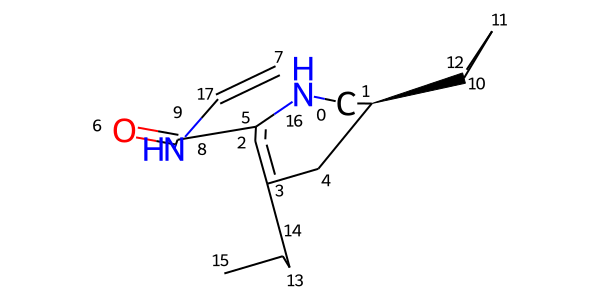

In [8]:
m, ref_m = test_ref_ligand(ligand_name)
m

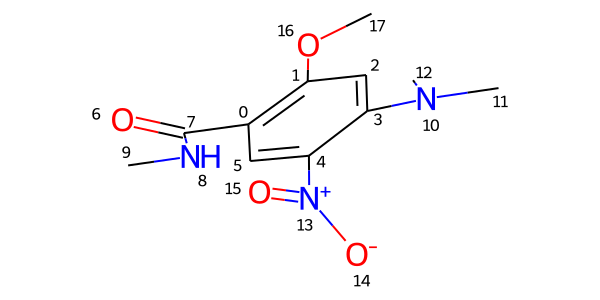

In [9]:
ref_m

In [10]:
def compare(ori_lig, gen_path=gen_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ori_lig)
    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    # protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ori_lig[ori_lig.rfind('rec')+4:ori_lig.rfind('lig')+3]
    # autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')
    autobox_ligand_file = os.path.join('../evaluation/ligand_based', ori_lig, ori_lig+'.sdf')

    ligand_file = os.path.join(gen_path, ori_lig+'.sdf')

    # out_folder = 'output_aromatic' if aromatic else 'output'
    # out_file = os.path.join(root_path, out_folder, gen_lig)
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    v.rotate(90)
    # v.animate({'interval':1000})
    
    return v

In [11]:
compare(ligand_name)

5ehq_A_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [30]:
lig_file = os.path.join(gen_path, ligand_name + '.sdf')
rdmol = Chem.MolFromMolFile(lig_file, sanitize=True)
pbmol = next(pybel.readfile("sdf", lig_file))
try:
    # rdmol = Chem.AddHs(rdmol)
    ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False, preprocess=False)
except:
    print('ligand init failed')
pp_atom_indices, pp_positions, pp_types, pp_index = extract_all_pp(ligand) # extract_pp(ligand) 
print(pp_types)

[1, 2, [5, 6], [5, 6], [5, 6], [5, 6], [5, 6]]


In [31]:
for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[ 0.2305 -0.6504 -1.2252]
['Hydrophobic'] 0
[3]
[-0.02215002 -0.07309999 -0.13388334]
['Aromatic'] 1
[0, 1, 2, 3, 4, 5]
[-2.0115 -0.9757 -2.0137]
['HBond_donor', 'HBond_acceptor'] 2
[6]
[-2.5523  0.4341  0.2394]
['HBond_donor', 'HBond_acceptor'] 3
[7]
[2.0157 0.6115 1.5601]
['HBond_donor', 'HBond_acceptor'] 4
[8]
[-0.2321  0.8421  2.42  ]
['HBond_donor', 'HBond_acceptor'] 5
[9]
[ 2.665e+00  2.000e-04 -5.770e-01]
['HBond_donor', 'HBond_acceptor'] 6
[10]


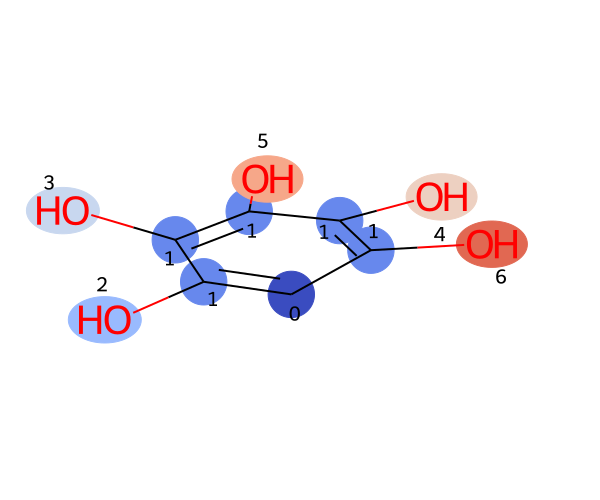

In [32]:
mol_, highlights = group_by(rdmol, ligand)
imgsize = (600, 500)
drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
drawer.DrawMolecule(mol_, **highlights)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:','')))

In [33]:
def load_mol(generated_path):
    mols = []

    for file in tqdm(os.listdir(generated_path)):
        m = Chem.MolFromMolFile(os.path.join(generated_path, file))
        mols.append(m)
        
    return mols

In [107]:
def test_ref_smi(smi, path):
    example = os.path.join(path, smi+'.sdf')
    m = Chem.MolFromMolFile(example)
    ref_m = Chem.MolFromSmiles(smi)
    return m, ref_m

In [108]:
def viz(smi, path):
    example = os.path.join(path, smi+'.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(example).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    
    return v

# VE Bridges

## EGNN

### With hydrogen
- MSE loss
- aromatic mode

- basic mode

### Without hydrogen
- MSE loss
- Using aromatic mode
- ve_bridge_egnn_QM9Dataset_2024-05-22_19_48_30.607674

In [4]:
# egnn wrong mse with softmax
# generated_path = '/data/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-19_01_37_37.204170/reconstructed_mols'

# egnn (mse)
# generated_path = '/data/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-19_23_37_06.648058/reconstructed_mols'
generated_path = '../lightning_logs/ve_bridge_egnn_QM9Dataset_2024-05-22_19_48_30.607674/reconstructed_mols_aromatic_mode'

# generated_path = '/data/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/vp_bridge_QM9Dataset_2024-05-19_01_34_10.875509/reconstructed_mols'

In [5]:
mols = []

for file in tqdm(os.listdir(generated_path)):
    m = Chem.MolFromMolFile(os.path.join(generated_path, file))
    mols.append(m)

  0%|                                                                                                                                                       | 4/5687 [00:00<02:30, 37.78it/s][15:07:45] atom 1 has specified valence (3) smaller than the drawn valence 4.
[15:07:45] atom 2 has specified valence (3) smaller than the drawn valence 4.
 16%|███████████████████████▎                                                                                                                            | 897/5687 [00:06<00:25, 189.84it/s][15:07:51] Explicit valence for atom # 13 N, 4, is greater than permitted
[15:07:51] Explicit valence for atom # 13 N, 4, is greater than permitted
 18%|█████████████████████████▉                                                                                                                         | 1003/5687 [00:07<00:19, 234.27it/s][15:07:52] atom 11 has specified valence (3) smaller than the drawn valence 4.
[15:07:52] atom 12 has specified valence (3) small

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4194/5687 [00:24<00:07, 187.39it/s][15:08:09] atom 8 has specified valence (3) smaller than the drawn valence 4.
[15:08:09] atom 3 has specified valence (3) smaller than the drawn valence 4.
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4564/5687 [00:26<00:05, 224.34it/s][15:08:11] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:08:11] atom 11 has specified valence (3) smaller than the drawn valence 4.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4653/5687 [00:26<00:03, 266.86it/s][15:08:11] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:08:11] atom 6 has specified valence (3) sma

In [6]:
len(os.listdir(generated_path)), len(mols)

(5687, 5687)

In [ ]:
smi = '[H]C1=C2[C@@]3([H])OC([H])([H])[C@@]3([H])[C@@]2([H])C([H])([H])C1([H])[H]'
m, ref_m = test_ref_smi(smi, path)
m

In [ ]:
viz(smi, path)

- basic mode

In [ ]:
path = '../lightning_logs/ve_bridge_egnn_QM9Dataset_2024-05-22_19_48_30.607674/reconstructed_mols'
mols = load_mol(path)
len(mols)

In [ ]:
smi = '[H]C1=C2[C@@]3([H])OC([H])([H])[C@@]3([H])[C@@]2([H])C([H])([H])C1([H])[H]'
m, ref_m = test_ref_smi(smi, path)
m

In [ ]:
viz(smi, path)

# VP Bridge

## EGNN

### With Hydrogen
- MSE loss
- Aromatic mode
- vp_bridge_egnn_QM9Dataset_2024-05-19_23_37_06.648058

**Prolly not completed**

In [27]:
path = '../lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-19_23_37_06.648058/reconstructed_mols_aromtic_mode'
mols = load_mol(path)
len(mols)

  2%|██▍                                                                                                                                                 | 142/8656 [00:04<04:21, 32.53it/s][16:00:19] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:00:19] Explicit valence for atom # 2 N, 4, is greater than permitted
  2%|███▌                                                                                                                                                | 210/8656 [00:07<04:13, 33.26it/s][16:00:21] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:00:21] Explicit valence for atom # 2 N, 4, is greater than permitted
  3%|███▊                                                                                                                                                | 226/8656 [00:07<05:00, 28.05it/s][16:00:21] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:00:22] Explicit valence for atom # 8 N, 4, is greater than permit

  7%|██████████▊                                                                                                                                         | 635/8656 [00:20<04:22, 30.54it/s][16:00:34] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:00:34] Explicit valence for atom # 7 N, 4, is greater than permitted
  8%|███████████▊                                                                                                                                        | 689/8656 [00:22<04:24, 30.17it/s][16:00:36] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:00:36] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:00:36] Explicit valence for atom # 3 N, 4, is greater than permitted
  8%|████████████▏                                                                                                                                       | 712/8656 [00:23<04:37, 28.65it/s][16:00:37] Explicit valence for atom # 8 N, 4, is greater than permitt

 14%|████████████████████▎                                                                                                                              | 1197/8656 [00:39<03:34, 34.73it/s][16:00:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:00:53] Explicit valence for atom # 1 N, 4, is greater than permitted
 16%|██████████████████████▊                                                                                                                            | 1346/8656 [00:44<04:06, 29.65it/s][16:00:58] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:00:58] Explicit valence for atom # 6 N, 4, is greater than permitted
 16%|███████████████████████▏                                                                                                                           | 1362/8656 [00:44<04:14, 28.66it/s][16:00:58] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:00:58] Explicit valence for atom # 5 N, 4, is greater than permitte

 21%|███████████████████████████████▍                                                                                                                   | 1849/8656 [01:00<03:45, 30.22it/s][16:01:15] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:01:15] Explicit valence for atom # 9 N, 4, is greater than permitted
 22%|███████████████████████████████▌                                                                                                                   | 1862/8656 [01:01<03:27, 32.77it/s][16:01:15] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:01:15] Explicit valence for atom # 9 N, 4, is greater than permitted
 22%|████████████████████████████████▏                                                                                                                  | 1899/8656 [01:02<03:56, 28.56it/s][16:01:16] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:01:16] Explicit valence for atom # 9 N, 4, is greater than permitt

 26%|██████████████████████████████████████                                                                                                             | 2238/8656 [01:13<03:03, 34.96it/s][16:01:27] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:01:27] Explicit valence for atom # 3 N, 4, is greater than permitted
 27%|████████████████████████████████████████                                                                                                           | 2361/8656 [01:17<03:11, 32.93it/s][16:01:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:01:31] Explicit valence for atom # 11 N, 4, is greater than permitted
 28%|████████████████████████████████████████▋                                                                                                          | 2393/8656 [01:18<03:43, 28.05it/s][16:01:32] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:01:32] Explicit valence for atom # 5 N, 4, is greater than permit

 32%|██████████████████████████████████████████████▎                                                                                                    | 2730/8656 [01:29<03:10, 31.09it/s][16:01:43] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:01:43] Explicit valence for atom # 8 N, 4, is greater than permitted
 32%|██████████████████████████████████████████████▍                                                                                                    | 2738/8656 [01:29<03:01, 32.63it/s][16:01:44] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:01:44] Explicit valence for atom # 5 N, 4, is greater than permitted
 32%|███████████████████████████████████████████████                                                                                                    | 2771/8656 [01:30<03:09, 31.07it/s][16:01:45] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:01:45] Explicit valence for atom # 7 N, 4, is greater than permitt

 34%|██████████████████████████████████████████████████▍                                                                                                | 2972/8656 [01:39<03:39, 25.90it/s][16:01:53] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:01:53] Explicit valence for atom # 12 N, 4, is greater than permitted
 35%|███████████████████████████████████████████████████▏                                                                                               | 3013/8656 [01:40<02:55, 32.07it/s][16:01:55] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:01:55] Explicit valence for atom # 5 N, 4, is greater than permitted
 35%|███████████████████████████████████████████████████▎                                                                                               | 3021/8656 [01:40<03:01, 31.06it/s][16:01:55] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:01:55] Explicit valence for atom # 6 N, 4, is greater than permitt

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 3398/8656 [01:53<03:07, 27.99it/s][16:02:07] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:02:07] Explicit valence for atom # 2 N, 4, is greater than permitted
 40%|██████████████████████████████████████████████████████████▉                                                                                        | 3467/8656 [01:55<02:42, 31.94it/s][16:02:09] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:02:09] Explicit valence for atom # 8 N, 4, is greater than permitted
 40%|███████████████████████████████████████████████████████████▏                                                                                       | 3488/8656 [01:55<02:32, 33.92it/s][16:02:10] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:02:10] Explicit valence for atom # 9 N, 4, is greater than permit

[16:02:16] Explicit valence for atom # 10 N, 4, is greater than permitted
 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 3691/8656 [02:03<02:40, 30.98it/s][16:02:17] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:02:17] Explicit valence for atom # 9 N, 4, is greater than permitted
 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 3732/8656 [02:04<03:24, 24.10it/s][16:02:18] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:02:18] Explicit valence for atom # 13 N, 4, is greater than permitted
 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 3816/8656 [02:07<02:34, 31.38it/s][16:02:21] Explicit valence for atom # 8 N, 4, is greater than perm

[16:02:31] Explicit valence for atom # 6 N, 4, is greater than permitted
 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 4137/8656 [02:17<02:27, 30.73it/s][16:02:31] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:02:31] Explicit valence for atom # 1 N, 4, is greater than permitted
 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 4149/8656 [02:17<02:21, 31.92it/s][16:02:31] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:02:31] Explicit valence for atom # 1 N, 4, is greater than permitted
 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 4206/8656 [02:19<02:23, 31.12it/s][16:02:34] Explicit valence for atom # 14 N, 4, is greater than permitt

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                       | 4469/8656 [02:27<02:10, 32.19it/s][16:02:42] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:02:42] Explicit valence for atom # 4 N, 4, is greater than permitted
 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 4533/8656 [02:29<02:05, 32.87it/s][16:02:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:02:44] atom 12 has specified valence (3) smaller than the drawn valence 4.
 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 4562/8656 [02:30<01:57, 34.87it/s][16:02:44] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:02:44] Explicit valence for atom # 6 N, 4, is greater than pe

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 4982/8656 [02:42<01:47, 34.30it/s][16:02:56] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:02:56] Explicit valence for atom # 11 N, 4, is greater than permitted
 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5043/8656 [02:44<01:51, 32.53it/s][16:02:58] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:02:58] Explicit valence for atom # 2 N, 4, is greater than permitted
 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 5088/8656 [02:45<01:37, 36.54it/s][16:02:59] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:02:59] Explicit valence for atom # 1 N, 4, is greater than permi

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 5322/8656 [02:52<01:35, 34.92it/s][16:03:06] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:03:07] Explicit valence for atom # 11 N, 4, is greater than permitted
 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 5360/8656 [02:53<01:40, 32.68it/s][16:03:08] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:03:08] Explicit valence for atom # 3 N, 4, is greater than permitted
 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 5389/8656 [02:54<01:31, 35.81it/s][16:03:09] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:03:09] Explicit valence for atom # 10 N, 4, is greater than permit

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 5833/8656 [03:08<04:40, 10.08it/s][16:03:23] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:03:23] Explicit valence for atom # 12 N, 4, is greater than permitted
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 5856/8656 [03:09<01:58, 23.66it/s][16:03:23] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:03:23] Explicit valence for atom # 14 N, 4, is greater than permitted
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 5863/8656 [03:09<01:42, 27.20it/s][16:03:24] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:03:24] Explicit valence for atom # 1 N, 4, is greater than permi

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 6277/8656 [03:21<00:58, 40.34it/s][16:03:36] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:03:36] Explicit valence for atom # 10 N, 4, is greater than permitted
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 6290/8656 [03:22<01:05, 36.09it/s][16:03:36] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:03:36] Explicit valence for atom # 6 N, 4, is greater than permitted
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 6306/8656 [03:22<01:13, 32.19it/s][16:03:37] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:03:37] Explicit valence for atom # 3 N, 4, is greater than permit

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 6835/8656 [03:38<00:50, 35.73it/s][16:03:52] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:03:52] Explicit valence for atom # 6 N, 4, is greater than permitted
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 6848/8656 [03:38<00:49, 36.51it/s][16:03:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:03:53] Explicit valence for atom # 9 N, 4, is greater than permitted
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 6888/8656 [03:39<00:48, 36.58it/s][16:03:54] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:03:54] Explicit valence for atom # 3 N, 4, is greater than permitte

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 7056/8656 [03:45<00:40, 39.48it/s][16:03:59] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:03:59] Explicit valence for atom # 5 N, 4, is greater than permitted
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 7077/8656 [03:45<00:43, 36.30it/s][16:03:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:03:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:04:00] Explicit valence for atom # 11 N, 4, is greater than permitted
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 7085/8656 [03:45<00:45, 34.86it/s][16:04:00] Explicit valence for atom # 0 N, 4, is greater than permit

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 7255/8656 [03:50<00:40, 34.19it/s][16:04:05] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:04:05] Explicit valence for atom # 10 N, 4, is greater than permitted
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 7315/8656 [03:52<00:36, 37.09it/s][16:04:06] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:04:06] Explicit valence for atom # 2 N, 4, is greater than permitted
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 7438/8656 [03:56<00:35, 34.52it/s][16:04:10] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:04:10] Explicit valence for atom # 7 N, 4, is greater than permit

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 7710/8656 [04:04<00:25, 37.68it/s][16:04:18] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:04:18] Explicit valence for atom # 13 N, 4, is greater than permitted
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 7768/8656 [04:05<00:21, 40.48it/s][16:04:20] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:04:20] Explicit valence for atom # 13 N, 4, is greater than permitted
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 7800/8656 [04:06<00:22, 37.50it/s][16:04:20] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:04:20] Explicit valence for atom # 9 N, 4, is greater than permi

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 8297/8656 [04:21<00:10, 34.30it/s][16:04:35] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:04:35] Explicit valence for atom # 6 N, 4, is greater than permitted
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 8340/8656 [04:22<00:08, 38.66it/s][16:04:36] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:04:36] Explicit valence for atom # 3 N, 4, is greater than permitted
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 8430/8656 [04:25<00:06, 35.29it/s][16:04:39] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:04:39] Explicit valence for atom # 5 N, 4, is greater than permitte

[16:04:42] Explicit valence for atom # 2 N, 4, is greater than permitted
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 8580/8656 [04:29<00:02, 32.39it/s][16:04:43] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:04:43] Explicit valence for atom # 7 N, 4, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 8647/8656 [04:31<00:00, 35.61it/s][16:04:45] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:04:45] Explicit valence for atom # 2 N, 4, is greater than permitted
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8656/8656 [04:31<00:00, 31.87it/s]


8656

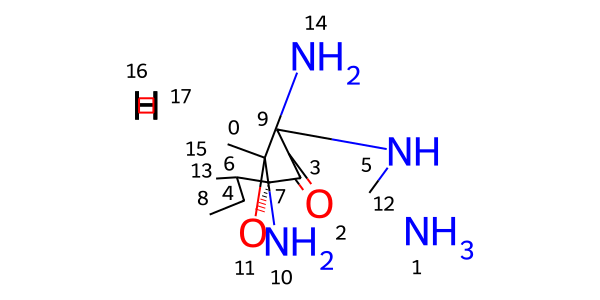

In [41]:
smi = '[H]c1nc(N([H])[H])c(C([H])([H])[H])n1C([H])([H])C([H])([H])[H]'
m, ref_m = test_ref_smi(smi, path)
m

In [42]:
viz(smi, path)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

- Basic mode

**Prolly not completed**

In [43]:
path1 = '../lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-19_23_37_06.648058/reconstructed_mols'
mols1 = load_mol(path1)
len(mols1)

  0%|                                                                                                                                        | 0/8612 [00:00<?, ?it/s][16:08:45] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:08:45] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:08:45] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:08:45] Explicit valence for atom # 4 N, 4, is greater than permitted
  1%|▊                                                                                                                             | 54/8612 [00:00<00:15, 535.44it/s][16:08:45] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:08:45] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:45] Explicit valence for atom # 13 N, 4, is greater than permitted
  1%|█▌                                                                                                                           | 108/8612 [00:00<00:16, 5

[16:08:46] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 10 N, 4, is greater than permitted
  8%|██████████▌                                                                                                                  | 728/8612 [00:01<00:15, 512.02it/s][16:08:46] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:46] Explicit valence for atom # 1 N, 4, is greater than permitted
  9%|███████████▎           

[16:08:47] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 15 N, 4, is greater than permitted
 16%|███████████████████▊                                                                                                        | 1372/8612 [00:02<00:14, 516.14it/s][16:08:47] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:08:47] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:47] Explicit valence

[16:08:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 3 N, 4, is greater than permitted
 22%|███████████████████████████▊                                                                                                | 1935/8612 [00:03<00:13, 488.23it/s][16:08:48] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:08:48] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:08:49] Explicit valence for atom # 0 N, 4, is greater than permitted
 23%|██████████████████████

 29%|███████████████████████████████████▍                                                                                        | 2462/8612 [00:04<00:11, 516.21it/s][16:08:49] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:08:49] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:50] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:08:50] Explicit valence for atom # 18 N, 4, is greater than permitted
[16:08:50] Explicit valence for atom # 14 N, 4, is greater than permitted
 29%|████████████████████████████████████▏                                                                                       | 2514/8612 [00:04<00:11, 508.39it/s][16:08:50] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:08:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:50] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:08:

 36%|████████████████████████████████████████████▊                                                                               | 3110/8612 [00:06<00:11, 480.20it/s][16:08:51] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 18 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 2 N, 4, is greater than permitted
 37%|█████████████████████████████████████████████▍                                                                              | 3160/8612 [00:06<00:11, 483.71it/s][16:08:51] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:08:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:

[16:08:52] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 3 N, 4, is greater than permitted
 43%|█████████████████████████████████████████████████████▉                                                                      | 3744/8612 [00:07<00:09, 539.06it/s][16:08:52] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:08:52] Explicit valence for atom # 7 N, 4, is greater than permitted
 44%|███████████████████████

[16:08:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:08:53] Explicit valence for atom # 8 N, 4, is greater than permitted
 50%|█████████████████████████████████████████████████████████████▊                                                              | 4293/8612 [00:08<00:08, 504.80it/s][16:08:53] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:53] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:08:53] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:53] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:53] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:53] Explicit valence for atom # 3 N, 4, is greater than permitted
 50%|██████████████████████████████████████████████████████████████▌                                                             | 4344/8612 [00:08<00:08, 502.69it/s][16:08:53] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:53]

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 5043/8612 [00:09<00:07, 507.78it/s][16:08:55] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:08:55] Explicit valence for atom # 8 N, 4, is greater than permitted
 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 5094/8612 [00:10<00:07, 501.17it/s][16:08:55

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 5655/8612 [00:11<00:06, 492.59it/s][16:08:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 3 N, 4, is greater than permitted
 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 5705/8612 [00:11<00:05, 491.11it/s][16:08:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:08:56] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:08:5

[16:08:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 13 N, 4, is greater than permitted
 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 6224/8612 [00:12<00:04, 492.89it/s][16:08:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 16 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:08:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:08:57] Explicit vale

[16:08:59] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 15 N, 4, is greater than permitted
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7348/8612 [00:14<00:02, 481.28it/s][16:08:59] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 14 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:08:59] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:08:59] Explicit valence

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 7897/8612 [00:15<00:01, 482.77it/s][16:09:00] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 10 N, 4, is greater than permitted
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 7946/8612 [00:15<00:01, 484.21it/s][16:09:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:09:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:09:0

8612

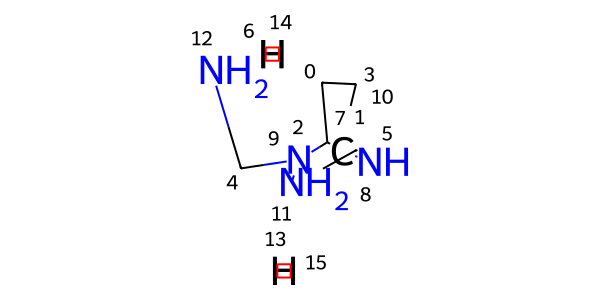

In [45]:
smi = '[H]C1=C2[C@@]3([H])OC([H])([H])[C@@]3([H])[C@@]2([H])C([H])([H])C1([H])[H]'
m, ref_m = test_ref_smi(smi, path1)
m

In [46]:
viz(smi, path1)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Without Hydrogen
vp_bridge_egnn_QM9Dataset_2024-05-22_19_48_30.573332

- MSE loss
- Aromatic mode

In [13]:
path = '../lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-22_19_48_30.573332/reconstructed_mols_aromatic_mode'
mols = load_mol(path)
len(mols)

  0%|▍                                                                                                                                                        | 24/9697 [00:00<04:43, 34.17it/s][22:37:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:37:33] Explicit valence for atom # 12 N, 4, is greater than permitted
  0%|▍                                                                                                                                                        | 28/9697 [00:00<04:45, 33.90it/s][22:37:33] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:37:33] Explicit valence for atom # 9 N, 4, is greater than permitted
  1%|█▌                                                                                                                                                       | 97/9697 [00:02<04:30, 35.44it/s][22:37:35] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:37:35] Explicit valence for atom # 4 N, 4, is greater

  4%|█████▍                                                                                                                                                  | 343/9697 [00:09<04:45, 32.75it/s][22:37:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:37:42] Explicit valence for atom # 9 N, 4, is greater than permitted
  4%|██████▌                                                                                                                                                 | 415/9697 [00:11<04:03, 38.11it/s][22:37:44] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:37:44] Explicit valence for atom # 8 N, 4, is greater than permitted
  5%|███████▏                                                                                                                                                | 455/9697 [00:12<03:49, 40.20it/s][22:37:45] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:37:45] Explicit valence for atom # 6 N, 4, is greater 

  6%|████████▊                                                                                                                                               | 560/9697 [00:15<04:11, 36.32it/s][22:37:48] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:37:48] Explicit valence for atom # 15 N, 4, is greater than permitted
  6%|████████▉                                                                                                                                               | 573/9697 [00:15<04:08, 36.78it/s][22:37:48] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:37:48] Explicit valence for atom # 4 N, 4, is greater than permitted
  6%|█████████                                                                                                                                               | 581/9697 [00:16<04:09, 36.48it/s][22:37:49] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:37:49] Explicit valence for atom # 0 N, 4, is greate

 10%|██████████████▊                                                                                                                                         | 945/9697 [00:26<03:53, 37.55it/s][22:37:58] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:37:59] Explicit valence for atom # 5 N, 4, is greater than permitted
 10%|██████████████▉                                                                                                                                         | 954/9697 [00:26<04:00, 36.36it/s][22:37:59] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:37:59] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:37:59] Explicit valence for atom # 9 N, 4, is greater than permitted
 10%|███████████████                                                                                                                                         | 958/9697 [00:26<04:02, 36.11it/s][22:37:59] Explicit valence for atom # 20 N, 4, is greate

 12%|█████████████████▌                                                                                                                                     | 1131/9697 [00:31<03:55, 36.43it/s][22:38:04] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:38:04] Explicit valence for atom # 4 N, 4, is greater than permitted
 12%|██████████████████▎                                                                                                                                    | 1173/9697 [00:32<03:41, 38.55it/s][22:38:05] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:38:05] Explicit valence for atom # 4 N, 4, is greater than permitted
 12%|██████████████████▋                                                                                                                                    | 1200/9697 [00:33<04:00, 35.29it/s][22:38:06] Explicit valence for atom # 17 N, 4, is greater than permitted
[22:38:06] Explicit valence for atom # 3 N, 4, is greater

 14%|█████████████████████▉                                                                                                                                 | 1405/9697 [00:39<04:05, 33.84it/s][22:38:11] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:38:11] Explicit valence for atom # 8 N, 4, is greater than permitted
 15%|██████████████████████                                                                                                                                 | 1418/9697 [00:39<03:41, 37.33it/s][22:38:12] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:38:12] Explicit valence for atom # 5 N, 4, is greater than permitted
 15%|██████████████████████▎                                                                                                                                | 1429/9697 [00:39<03:26, 40.02it/s][22:38:12] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:38:12] Explicit valence for atom # 5 N, 4, is greater 

 18%|███████████████████████████▍                                                                                                                           | 1764/9697 [00:48<03:43, 35.56it/s][22:38:21] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:38:21] Explicit valence for atom # 5 N, 4, is greater than permitted
 18%|███████████████████████████▊                                                                                                                           | 1785/9697 [00:49<03:38, 36.18it/s][22:38:22] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:38:22] Explicit valence for atom # 17 N, 4, is greater than permitted
[22:38:22] Explicit valence for atom # 4 N, 4, is greater than permitted
 21%|███████████████████████████████▊                                                                                                                       | 2039/9697 [00:56<03:27, 36.86it/s][22:38:29] Explicit valence for atom # 11 N, 4, is greater

 21%|████████████████████████████████                                                                                                                       | 2056/9697 [00:57<03:37, 35.18it/s][22:38:29] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:38:30] Explicit valence for atom # 4 N, 4, is greater than permitted
 22%|█████████████████████████████████                                                                                                                      | 2126/9697 [00:59<03:37, 34.77it/s][22:38:31] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:38:31] Explicit valence for atom # 10 N, 4, is greater than permitted
 22%|█████████████████████████████████▋                                                                                                                     | 2162/9697 [01:00<03:36, 34.79it/s][22:38:32] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:38:32] Explicit valence for atom # 3 N, 4, is greater

 23%|███████████████████████████████████▏                                                                                                                   | 2262/9697 [01:02<03:29, 35.41it/s][22:38:35] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:38:35] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:38:35] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:38:35] Explicit valence for atom # 17 N, 4, is greater than permitted
 24%|███████████████████████████████████▌                                                                                                                   | 2282/9697 [01:03<03:30, 35.27it/s][22:38:36] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:38:36] Explicit valence for atom # 11 N, 4, is greater than permitted
 24%|███████████████████████████████████▋                                                                                                                   | 2290/9697 [01:03

 26%|██████████████████████████████████████▋                                                                                                                | 2486/9697 [01:09<03:04, 38.99it/s][22:38:41] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:38:41] Explicit valence for atom # 23 N, 4, is greater than permitted
[22:38:41] Explicit valence for atom # 8 N, 4, is greater than permitted
 26%|███████████████████████████████████████▎                                                                                                               | 2523/9697 [01:10<03:18, 36.11it/s][22:38:42] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:38:42] Explicit valence for atom # 9 N, 4, is greater than permitted
 26%|███████████████████████████████████████▌                                                                                                               | 2543/9697 [01:10<03:32, 33.60it/s][22:38:43] Explicit valence for atom # 1 N, 4, is greate

 28%|██████████████████████████████████████████▋                                                                                                            | 2739/9697 [01:16<03:16, 35.39it/s][22:38:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:38:49] Explicit valence for atom # 11 N, 4, is greater than permitted
 29%|███████████████████████████████████████████▌                                                                                                           | 2800/9697 [01:18<03:06, 36.90it/s][22:38:50] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:38:50] Explicit valence for atom # 8 N, 4, is greater than permitted
 29%|███████████████████████████████████████████▋                                                                                                           | 2804/9697 [01:18<03:11, 36.01it/s][22:38:51] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:38:51] Explicit valence for atom # 10 N, 4, is greate

 31%|██████████████████████████████████████████████▊                                                                                                        | 3010/9697 [01:23<02:53, 38.65it/s][22:38:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:38:56] Explicit valence for atom # 16 N, 4, is greater than permitted
 31%|███████████████████████████████████████████████▏                                                                                                       | 3030/9697 [01:24<03:07, 35.53it/s][22:38:57] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:38:57] Explicit valence for atom # 2 N, 4, is greater than permitted
 32%|███████████████████████████████████████████████▉                                                                                                       | 3079/9697 [01:25<02:52, 38.39it/s][22:38:58] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:38:58] Explicit valence for atom # 4 N, 4, is greater

 33%|██████████████████████████████████████████████████▍                                                                                                    | 3238/9697 [01:30<02:47, 38.54it/s][22:39:03] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:39:03] Explicit valence for atom # 13 N, 4, is greater than permitted
 34%|███████████████████████████████████████████████████▌                                                                                                   | 3314/9697 [01:32<03:00, 35.35it/s][22:39:05] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:39:05] Explicit valence for atom # 9 N, 4, is greater than permitted
 35%|█████████████████████████████████████████████████████                                                                                                  | 3409/9697 [01:35<02:58, 35.19it/s][22:39:07] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:39:07] Explicit valence for atom # 16 N, 4, is greate

 38%|████████████████████████████████████████████████████████▋                                                                                              | 3644/9697 [01:41<02:56, 34.24it/s][22:39:14] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:39:14] Explicit valence for atom # 10 N, 4, is greater than permitted
 38%|█████████████████████████████████████████████████████████▋                                                                                             | 3704/9697 [01:43<02:39, 37.66it/s][22:39:16] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:39:16] Explicit valence for atom # 15 N, 4, is greater than permitted
 39%|██████████████████████████████████████████████████████████▋                                                                                            | 3770/9697 [01:45<02:44, 36.08it/s][22:39:17] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:39:17] Explicit valence for atom # 9 N, 4, is greate

 40%|████████████████████████████████████████████████████████████▎                                                                                          | 3877/9697 [01:47<02:39, 36.44it/s][22:39:20] Explicit valence for atom # 19 N, 4, is greater than permitted
[22:39:20] Explicit valence for atom # 18 N, 4, is greater than permitted
 40%|████████████████████████████████████████████████████████████▌                                                                                          | 3893/9697 [01:48<02:32, 38.01it/s][22:39:21] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:39:21] Explicit valence for atom # 5 N, 4, is greater than permitted
 40%|█████████████████████████████████████████████████████████████                                                                                          | 3922/9697 [01:49<02:38, 36.41it/s][22:39:22] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:39:22] Explicit valence for atom # 11 N, 4, is greate

 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 4156/9697 [01:55<02:39, 34.76it/s][22:39:28] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:39:28] Explicit valence for atom # 15 N, 4, is greater than permitted
 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 4227/9697 [01:57<02:15, 40.48it/s][22:39:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:39:30] Explicit valence for atom # 18 N, 4, is greater than permitted
 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 4254/9697 [01:58<02:22, 38.20it/s][22:39:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:39:31] Explicit valence for atom # 8 N, 4, is greater

 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 4315/9697 [01:59<02:39, 33.85it/s][22:39:32] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:39:32] Explicit valence for atom # 1 N, 4, is greater than permitted
 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 4349/9697 [02:00<02:31, 35.21it/s][22:39:33] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:39:33] Explicit valence for atom # 2 N, 4, is greater than permitted
 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 4430/9697 [02:03<02:25, 36.11it/s][22:39:35] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:39:35] Explicit valence for atom # 7 N, 4, is greater 

 48%|████████████████████████████████████████████████████████████████████████                                                                               | 4630/9697 [02:08<02:17, 36.78it/s][22:39:41] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:39:41] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:39:41] Explicit valence for atom # 3 N, 4, is greater than permitted
 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 4708/9697 [02:10<02:07, 39.03it/s][22:39:43] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:39:43] Explicit valence for atom # 8 N, 4, is greater than permitted
 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 4720/9697 [02:11<02:16, 36.49it/s][22:39:43] Explicit valence for atom # 6 N, 4, is greater 

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 4849/9697 [02:14<02:10, 37.07it/s][22:39:47] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:39:47] Explicit valence for atom # 2 N, 4, is greater than permitted
 50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 4869/9697 [02:15<02:16, 35.50it/s][22:39:47] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:39:47] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:39:48] Explicit valence for atom # 12 N, 4, is greater than permitted
 50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 4873/9697 [02:15<02:17, 35.19it/s][22:39:48] Explicit valence for atom # 7 N, 4, is greate

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 5110/9697 [02:21<02:08, 35.80it/s][22:39:54] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:39:54] Explicit valence for atom # 4 N, 4, is greater than permitted
 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 5144/9697 [02:22<02:04, 36.58it/s][22:39:55] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:39:55] Explicit valence for atom # 14 N, 4, is greater than permitted
 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5162/9697 [02:22<01:57, 38.60it/s][22:39:55] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:39:55] Explicit valence for atom # 4 N, 4, is greate

 55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5364/9697 [02:28<01:56, 37.29it/s][22:40:01] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:40:01] Explicit valence for atom # 4 N, 4, is greater than permitted
 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5478/9697 [02:31<01:56, 36.17it/s][22:40:04] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:40:04] Explicit valence for atom # 16 N, 4, is greater than permitted
 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5500/9697 [02:32<01:53, 37.01it/s][22:40:05] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:40:05] Explicit valence for atom # 5 N, 4, is greater

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 5815/9697 [02:40<01:46, 36.52it/s][22:40:13] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:40:13] Explicit valence for atom # 11 N, 4, is greater than permitted
 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 5848/9697 [02:41<01:47, 35.64it/s][22:40:14] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:40:14] Explicit valence for atom # 4 N, 4, is greater than permitted
 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 5877/9697 [02:42<01:43, 36.74it/s][22:40:15] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:40:15] Explicit valence for atom # 2 N, 4, is greate

 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 5956/9697 [02:44<01:45, 35.31it/s][22:40:17] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:40:17] Explicit valence for atom # 2 N, 4, is greater than permitted
 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6068/9697 [02:47<01:30, 40.09it/s][22:40:20] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:40:20] Explicit valence for atom # 9 N, 4, is greater than permitted
 63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6078/9697 [02:48<01:29, 40.42it/s][22:40:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:40:21] Explicit valence for atom # 3 N, 4, is greater

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6246/9697 [02:52<01:26, 39.76it/s][22:40:25] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:40:25] Explicit valence for atom # 18 N, 4, is greater than permitted
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6333/9697 [02:55<01:35, 35.23it/s][22:40:28] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:40:28] Explicit valence for atom # 14 N, 4, is greater than permitted
 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6390/9697 [02:56<01:28, 37.20it/s][22:40:29] Explicit valence for atom # 22 N, 4, is greater than permitted
[22:40:29] Explicit valence for atom # 0 N, 4, is great

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6532/9697 [03:00<01:28, 35.59it/s][22:40:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:40:33] Explicit valence for atom # 1 N, 4, is greater than permitted
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6576/9697 [03:01<01:22, 37.86it/s][22:40:34] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:40:34] Explicit valence for atom # 7 N, 4, is greater than permitted
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6611/9697 [03:02<01:19, 38.75it/s][22:40:35] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:40:35] Explicit valence for atom # 10 N, 4, is greate

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6716/9697 [03:05<01:28, 33.82it/s][22:40:38] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:40:38] Explicit valence for atom # 1 N, 4, is greater than permitted
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6725/9697 [03:06<01:25, 34.83it/s][22:40:38] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:40:39] Explicit valence for atom # 20 N, 4, is greater than permitted
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6745/9697 [03:06<01:19, 36.98it/s][22:40:39] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:40:39] Explicit valence for atom # 4 N, 4, is greate

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7033/9697 [03:14<01:12, 36.93it/s][22:40:47] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:40:47] Explicit valence for atom # 0 N, 4, is greater than permitted
 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7057/9697 [03:15<01:13, 36.04it/s][22:40:48] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:40:48] Explicit valence for atom # 18 N, 4, is greater than permitted
[22:40:48] Explicit valence for atom # 1 N, 4, is greater than permitted
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7113/9697 [03:16<01:12, 35.70it/s][22:40:49] Explicit valence for atom # 11 N, 4, is greate

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7193/9697 [03:19<01:13, 34.27it/s][22:40:51] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:40:51] Explicit valence for atom # 2 N, 4, is greater than permitted
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7228/9697 [03:20<01:02, 39.64it/s][22:40:52] Explicit valence for atom # 18 N, 4, is greater than permitted
[22:40:52] Explicit valence for atom # 16 N, 4, is greater than permitted
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7265/9697 [03:21<01:07, 36.02it/s][22:40:53] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:40:53] Explicit valence for atom # 5 N, 4, is greater

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7499/9697 [03:27<00:59, 36.75it/s][22:41:00] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:41:00] Explicit valence for atom # 14 N, 4, is greater than permitted
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7623/9697 [03:30<00:55, 37.05it/s][22:41:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:41:03] Explicit valence for atom # 9 N, 4, is greater than permitted
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7703/9697 [03:33<00:54, 36.65it/s][22:41:05] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:41:05] Explicit valence for atom # 0 N, 4, is greate

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7723/9697 [03:33<00:57, 34.07it/s][22:41:06] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:41:06] Explicit valence for atom # 15 N, 4, is greater than permitted
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7731/9697 [03:33<00:55, 35.28it/s][22:41:06] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:41:06] Explicit valence for atom # 18 N, 4, is greater than permitted
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7769/9697 [03:34<00:52, 36.41it/s][22:41:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:41:07] Explicit valence for atom # 4 N, 4, is greate

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8036/9697 [03:42<00:47, 35.22it/s][22:41:14] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:41:14] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:41:14] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:41:14] Explicit valence for atom # 7 N, 4, is greater than permitted
 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8041/9697 [03:42<00:43, 38.13it/s][22:41:15] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:41:15] Explicit valence for atom # 3 N, 4, is greater than permitted
 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8045/9697 [03:42<0

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8209/9697 [03:46<00:36, 40.46it/s][22:41:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:41:19] Explicit valence for atom # 18 N, 4, is greater than permitted
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8218/9697 [03:47<00:39, 37.66it/s][22:41:20] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:41:20] Explicit valence for atom # 1 N, 4, is greater than permitted
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8292/9697 [03:49<00:41, 33.64it/s][22:41:22] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:41:22] Explicit valence for atom # 15 N, 4, is great

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8489/9697 [03:54<00:31, 38.63it/s][22:41:27] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:41:27] Explicit valence for atom # 13 N, 4, is greater than permitted
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8537/9697 [03:55<00:27, 41.44it/s][22:41:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[22:41:28] Explicit valence for atom # 13 N, 4, is greater than permitted
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8601/9697 [03:57<00:31, 35.12it/s][22:41:30] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:41:30] Explicit valence for atom # 20 N, 4, is grea

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8773/9697 [04:02<00:25, 35.84it/s][22:41:35] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:41:35] Explicit valence for atom # 6 N, 4, is greater than permitted
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8781/9697 [04:02<00:24, 37.56it/s][22:41:35] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:41:35] Explicit valence for atom # 4 N, 4, is greater than permitted
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8853/9697 [04:04<00:21, 38.49it/s][22:41:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:41:37] Explicit valence for atom # 12 N, 4, is greater

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9181/9697 [04:13<00:15, 33.89it/s][22:41:46] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:41:46] Explicit valence for atom # 3 N, 4, is greater than permitted
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9239/9697 [04:15<00:12, 36.19it/s][22:41:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:41:48] Explicit valence for atom # 7 N, 4, is greater than permitted
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9321/9697 [04:17<00:10, 35.97it/s][22:41:50] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:41:50] Explicit valence for atom # 1 N, 4, is greater 

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9380/9697 [04:19<00:08, 36.72it/s][22:41:51] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:41:51] Explicit valence for atom # 4 N, 4, is greater than permitted
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9397/9697 [04:19<00:07, 38.04it/s][22:41:52] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:41:52] Explicit valence for atom # 8 N, 4, is greater than permitted
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9445/9697 [04:20<00:07, 32.89it/s][22:41:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:41:53] Explicit valence for atom # 17 N, 4, is greater 

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9583/9697 [04:24<00:02, 39.59it/s][22:41:57] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:41:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:41:57] Explicit valence for atom # 5 N, 4, is greater than permitted
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9591/9697 [04:24<00:02, 38.24it/s][22:41:57] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:41:57] Explicit valence for atom # 7 N, 4, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9666/9697 [04:26<00:00, 34.76it/s][22:41:59] Explicit valence for atom # 10 N, 4, is greater

9697

In [14]:
smi = '[H]C1=C2[C@@]3([H])OC([H])([H])[C@@]3([H])[C@@]2([H])C([H])([H])C1([H])[H]'
m, ref_m = test_ref_smi(smi, path)
m

[22:42:00] Explicit valence for atom # 16 N, 4, is greater than permitted


In [15]:
viz(smi, path)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

- Basic mode

In [16]:
path = '../lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-22_19_48_30.573332/reconstructed_mols'
mols = load_mol(path)
len(mols)

  1%|█                                                                                                                                                        | 64/9739 [00:01<03:42, 43.53it/s][22:42:19] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:42:19] Explicit valence for atom # 16 N, 4, is greater than permitted
  1%|█                                                                                                                                                        | 69/9739 [00:01<03:35, 44.96it/s][22:42:19] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:42:19] Explicit valence for atom # 12 N, 4, is greater than permitted
  1%|█▎                                                                                                                                                       | 85/9739 [00:01<03:32, 45.34it/s][22:42:20] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:42:20] Explicit valence for atom # 3 N, 4, is great

  4%|█████▊                                                                                                                                                  | 370/9739 [00:08<02:59, 52.22it/s][22:42:26] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:42:26] Explicit valence for atom # 4 N, 4, is greater than permitted
  4%|██████▏                                                                                                                                                 | 394/9739 [00:08<02:56, 52.98it/s][22:42:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:42:26] Explicit valence for atom # 11 N, 4, is greater than permitted
  4%|██████▋                                                                                                                                                 | 431/9739 [00:09<02:53, 53.51it/s][22:42:27] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:42:27] Explicit valence for atom # 8 N, 4, is greater

  6%|█████████                                                                                                                                               | 580/9739 [00:11<02:51, 53.53it/s][22:42:29] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:42:29] Explicit valence for atom # 7 N, 4, is greater than permitted
  6%|█████████▎                                                                                                                                              | 598/9739 [00:12<02:50, 53.50it/s][22:42:30] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:42:30] Explicit valence for atom # 5 N, 4, is greater than permitted
  6%|█████████▌                                                                                                                                              | 616/9739 [00:12<02:53, 52.72it/s][22:42:30] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:42:30] Explicit valence for atom # 9 N, 4, is greater t

  9%|█████████████▏                                                                                                                                          | 848/9739 [00:16<02:40, 55.24it/s][22:42:34] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:42:34] Explicit valence for atom # 20 N, 4, is greater than permitted
[22:42:34] Explicit valence for atom # 14 N, 4, is greater than permitted
  9%|█████████████▎                                                                                                                                          | 854/9739 [00:16<02:40, 55.39it/s][22:42:34] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:42:34] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:42:34] Explicit valence for atom # 18 N, 4, is greater than permitted
  9%|██████████████▎                                                                                                                                         | 914/9739 [00:17<

 12%|█████████████████▊                                                                                                                                     | 1149/9739 [00:22<02:26, 58.64it/s][22:42:40] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:42:40] Explicit valence for atom # 20 N, 4, is greater than permitted
 12%|██████████████████▍                                                                                                                                    | 1187/9739 [00:22<02:38, 53.88it/s][22:42:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:42:41] Explicit valence for atom # 10 N, 4, is greater than permitted
 12%|██████████████████▋                                                                                                                                    | 1205/9739 [00:23<02:34, 55.24it/s][22:42:41] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:42:41] Explicit valence for atom # 0 N, 4, is greater

 14%|█████████████████████▊                                                                                                                                 | 1404/9739 [00:26<02:17, 60.66it/s][22:42:44] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:42:44] Explicit valence for atom # 10 N, 4, is greater than permitted
 15%|██████████████████████                                                                                                                                 | 1425/9739 [00:26<02:17, 60.62it/s][22:42:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:42:45] Explicit valence for atom # 12 N, 4, is greater than permitted
 15%|██████████████████████▊                                                                                                                                | 1472/9739 [00:27<02:21, 58.29it/s][22:42:45] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:42:45] Explicit valence for atom # 11 N, 4, is great

 18%|███████████████████████████▋                                                                                                                           | 1789/9739 [00:33<02:16, 58.11it/s][22:42:51] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:42:51] Explicit valence for atom # 4 N, 4, is greater than permitted
 19%|████████████████████████████▍                                                                                                                          | 1837/9739 [00:33<02:11, 60.26it/s][22:42:52] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:42:52] Explicit valence for atom # 6 N, 4, is greater than permitted
 19%|████████████████████████████▉                                                                                                                          | 1865/9739 [00:34<02:09, 60.70it/s][22:42:52] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:42:52] Explicit valence for atom # 9 N, 4, is greater 

 22%|████████████████████████████████▉                                                                                                                      | 2124/9739 [00:38<02:12, 57.39it/s][22:42:56] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:42:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:42:56] Explicit valence for atom # 4 N, 4, is greater than permitted
 22%|█████████████████████████████████                                                                                                                      | 2131/9739 [00:38<02:07, 59.84it/s][22:42:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:42:57] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:42:57] Explicit valence for atom # 13 N, 4, is greater than permitted
 22%|█████████████████████████████████▎                                                                                                                     | 2145/9739 [00:39<0

 25%|██████████████████████████████████████                                                                                                                 | 2456/9739 [00:44<02:23, 50.92it/s][22:43:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:43:02] Explicit valence for atom # 8 N, 4, is greater than permitted
 26%|██████████████████████████████████████▋                                                                                                                | 2492/9739 [00:45<02:23, 50.38it/s][22:43:03] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:43:03] Explicit valence for atom # 21 N, 4, is greater than permitted
 26%|██████████████████████████████████████▋                                                                                                                | 2498/9739 [00:45<02:26, 49.37it/s][22:43:03] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:43:03] Explicit valence for atom # 18 N, 4, is greate

 28%|██████████████████████████████████████████▋                                                                                                            | 2750/9739 [00:49<02:02, 57.22it/s][22:43:08] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:43:08] Explicit valence for atom # 5 N, 4, is greater than permitted
 28%|██████████████████████████████████████████▊                                                                                                            | 2765/9739 [00:50<01:53, 61.52it/s][22:43:08] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:43:08] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:43:08] Explicit valence for atom # 11 N, 4, is greater than permitted
 29%|████████████████████████████████████████████                                                                                                           | 2842/9739 [00:51<01:56, 59.38it/s][22:43:09] Explicit valence for atom # 10 N, 4, is greate

 31%|███████████████████████████████████████████████▎                                                                                                       | 3049/9739 [00:55<01:59, 55.96it/s][22:43:13] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:43:13] Explicit valence for atom # 5 N, 4, is greater than permitted
 31%|███████████████████████████████████████████████▍                                                                                                       | 3061/9739 [00:55<01:59, 55.87it/s][22:43:13] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:43:13] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:43:13] Explicit valence for atom # 7 N, 4, is greater than permitted
 32%|███████████████████████████████████████████████▌                                                                                                       | 3068/9739 [00:55<01:57, 56.79it/s][22:43:13] Explicit valence for atom # 3 N, 4, is greater 

 34%|████████████████████████████████████████████████████                                                                                                   | 3357/9739 [01:00<02:10, 49.00it/s][22:43:18] Explicit valence for atom # 17 N, 4, is greater than permitted
[22:43:18] Explicit valence for atom # 14 N, 4, is greater than permitted
 35%|████████████████████████████████████████████████████▏                                                                                                  | 3369/9739 [01:00<02:07, 49.95it/s][22:43:19] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:43:19] Explicit valence for atom # 3 N, 4, is greater than permitted
 35%|████████████████████████████████████████████████████▌                                                                                                  | 3391/9739 [01:01<02:12, 47.87it/s][22:43:19] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:43:19] Explicit valence for atom # 10 N, 4, is greate

 37%|████████████████████████████████████████████████████████                                                                                               | 3616/9739 [01:06<02:16, 44.85it/s][22:43:24] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:43:24] Explicit valence for atom # 10 N, 4, is greater than permitted
 38%|████████████████████████████████████████████████████████▊                                                                                              | 3662/9739 [01:07<02:15, 44.81it/s][22:43:25] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:43:25] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:43:25] Explicit valence for atom # 15 N, 4, is greater than permitted
 38%|█████████████████████████████████████████████████████████▍                                                                                             | 3704/9739 [01:08<02:07, 47.28it/s][22:43:26] Explicit valence for atom # 20 N, 4, is grea

 40%|████████████████████████████████████████████████████████████▊                                                                                          | 3925/9739 [01:12<02:11, 44.34it/s][22:43:31] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:43:31] Explicit valence for atom # 1 N, 4, is greater than permitted
 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 3965/9739 [01:13<02:07, 45.22it/s][22:43:31] Explicit valence for atom # 20 N, 4, is greater than permitted
[22:43:31] Explicit valence for atom # 6 N, 4, is greater than permitted
 41%|██████████████████████████████████████████████████████████████                                                                                         | 4006/9739 [01:14<02:00, 47.43it/s][22:43:32] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:43:32] Explicit valence for atom # 13 N, 4, is greater

 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 4202/9739 [01:19<02:08, 42.93it/s][22:43:37] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:43:37] Explicit valence for atom # 7 N, 4, is greater than permitted
 44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 4240/9739 [01:19<01:57, 46.74it/s][22:43:37] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:43:38] Explicit valence for atom # 9 N, 4, is greater than permitted
 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 4333/9739 [01:21<02:01, 44.34it/s][22:43:39] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:43:40] Explicit valence for atom # 8 N, 4, is greater t

 45%|████████████████████████████████████████████████████████████████████▋                                                                                  | 4431/9739 [01:24<01:56, 45.40it/s][22:43:42] Explicit valence for atom # 17 N, 4, is greater than permitted
[22:43:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:43:42] Explicit valence for atom # 0 N, 4, is greater than permitted
 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 4473/9739 [01:25<01:52, 46.63it/s][22:43:43] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:43:43] Explicit valence for atom # 16 N, 4, is greater than permitted
 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 4503/9739 [01:25<01:54, 45.76it/s][22:43:43] Explicit valence for atom # 0 N, 4, is greater

 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 4704/9739 [01:29<01:42, 49.10it/s][22:43:47] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:43:47] Explicit valence for atom # 12 N, 4, is greater than permitted
 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 4710/9739 [01:29<01:39, 50.77it/s][22:43:48] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:43:48] Explicit valence for atom # 10 N, 4, is greater than permitted
 48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 4722/9739 [01:30<01:38, 50.88it/s][22:43:48] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:43:48] Explicit valence for atom # 8 N, 4, is greater

 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 5095/9739 [01:37<01:36, 47.98it/s][22:43:55] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:43:56] Explicit valence for atom # 9 N, 4, is greater than permitted
 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 5118/9739 [01:38<01:34, 49.13it/s][22:43:56] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:43:56] Explicit valence for atom # 13 N, 4, is greater than permitted
 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 5154/9739 [01:39<01:31, 50.09it/s][22:43:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:43:57] Explicit valence for atom # 2 N, 4, is greater 

 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5284/9739 [01:41<01:27, 51.05it/s][22:43:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[22:43:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:43:59] Explicit valence for atom # 7 N, 4, is greater than permitted
 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5306/9739 [01:42<01:35, 46.50it/s][22:44:00] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:44:00] Explicit valence for atom # 6 N, 4, is greater than permitted
 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5364/9739 [01:43<01:27, 49.78it/s][22:44:01] Explicit valence for atom # 3 N, 4, is greater t

 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5532/9739 [01:46<01:31, 45.98it/s][22:44:04] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:44:05] Explicit valence for atom # 1 N, 4, is greater than permitted
 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5556/9739 [01:47<01:22, 50.55it/s][22:44:05] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:44:05] Explicit valence for atom # 11 N, 4, is greater than permitted
 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5574/9739 [01:47<01:22, 50.60it/s][22:44:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:44:05] Explicit valence for atom # 9 N, 4, is greater

 59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5785/9739 [01:52<01:21, 48.41it/s][22:44:10] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:44:10] Explicit valence for atom # 10 N, 4, is greater than permitted
 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5791/9739 [01:52<01:18, 50.43it/s][22:44:10] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:44:10] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:44:10] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:44:10] Explicit valence for atom # 14 N, 4, is greater than permitted
 60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5814/9739 [01:52<

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6019/9739 [01:56<01:23, 44.66it/s][22:44:14] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:44:14] Explicit valence for atom # 8 N, 4, is greater than permitted
 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6024/9739 [01:56<01:22, 44.87it/s][22:44:14] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:44:15] Explicit valence for atom # 7 N, 4, is greater than permitted
 63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6105/9739 [01:58<01:18, 46.56it/s][22:44:16] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:44:16] Explicit valence for atom # 10 N, 4, is greater

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6286/9739 [02:02<01:07, 50.88it/s][22:44:20] Explicit valence for atom # 20 N, 4, is greater than permitted
[22:44:20] Explicit valence for atom # 0 N, 4, is greater than permitted
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6316/9739 [02:02<01:02, 54.60it/s][22:44:20] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:44:20] Explicit valence for atom # 5 N, 4, is greater than permitted
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6322/9739 [02:02<01:05, 52.24it/s][22:44:21] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:44:21] Explicit valence for atom # 13 N, 4, is greater

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6637/9739 [02:09<00:58, 53.38it/s][22:44:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:44:27] Explicit valence for atom # 12 N, 4, is greater than permitted
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6643/9739 [02:09<00:59, 52.38it/s][22:44:27] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:44:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:44:27] Explicit valence for atom # 4 N, 4, is greater than permitted
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6667/9739 [02:09<00:58, 52.75it/s][22:44:27] Explicit valence for atom # 5 N, 4, is greater 

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 6891/9739 [02:14<00:56, 50.40it/s][22:44:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:44:32] Explicit valence for atom # 7 N, 4, is greater than permitted
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 6903/9739 [02:14<00:56, 50.35it/s][22:44:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:44:32] Explicit valence for atom # 9 N, 4, is greater than permitted
 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 6919/9739 [02:15<01:01, 45.95it/s][22:44:33] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:44:33] Explicit valence for atom # 14 N, 4, is greater 

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7166/9739 [02:20<00:56, 45.90it/s][22:44:38] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:44:38] Explicit valence for atom # 5 N, 4, is greater than permitted
 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7176/9739 [02:20<00:55, 46.35it/s][22:44:38] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:44:38] Explicit valence for atom # 14 N, 4, is greater than permitted
 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7196/9739 [02:20<00:55, 45.74it/s][22:44:38] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:44:38] Explicit valence for atom # 14 N, 4, is greate

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7480/9739 [02:26<00:40, 56.34it/s][22:44:44] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:44:44] Explicit valence for atom # 2 N, 4, is greater than permitted
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7493/9739 [02:26<00:38, 57.68it/s][22:44:44] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:44:44] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:44:44] Explicit valence for atom # 4 N, 4, is greater than permitted
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7519/9739 [02:27<00:36, 60.54it/s][22:44:45] Explicit valence for atom # 2 N, 4, is greate

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7763/9739 [02:31<00:35, 56.24it/s][22:44:49] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:44:49] Explicit valence for atom # 7 N, 4, is greater than permitted
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7782/9739 [02:31<00:34, 56.17it/s][22:44:49] Explicit valence for atom # 5 N, 4, is greater than permitted
[22:44:49] Explicit valence for atom # 4 N, 4, is greater than permitted
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7788/9739 [02:32<00:34, 57.05it/s][22:44:50] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:44:50] Explicit valence for atom # 6 N, 4, is greater 

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8125/9739 [02:38<00:29, 55.53it/s][22:44:56] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:44:56] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:44:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:44:56] Explicit valence for atom # 20 N, 4, is greater than permitted
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8138/9739 [02:38<00:28, 56.98it/s][22:44:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[22:44:56] Explicit valence for atom # 14 N, 4, is greater than permitted
 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8193/9739 [02:39<

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8311/9739 [02:41<00:25, 55.62it/s][22:44:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:44:59] Explicit valence for atom # 24 N, 4, is greater than permitted
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8317/9739 [02:41<00:25, 55.76it/s][22:44:59] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:44:59] Explicit valence for atom # 5 N, 4, is greater than permitted
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8335/9739 [02:41<00:27, 51.24it/s][22:44:59] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:44:59] Explicit valence for atom # 8 N, 4, is greate

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8586/9739 [02:46<00:20, 55.27it/s][22:45:04] Explicit valence for atom # 9 N, 4, is greater than permitted
[22:45:04] Explicit valence for atom # 12 N, 4, is greater than permitted
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8604/9739 [02:47<00:21, 52.30it/s][22:45:05] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:45:05] Explicit valence for atom # 1 N, 4, is greater than permitted
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8641/9739 [02:47<00:20, 54.35it/s][22:45:05] Explicit valence for atom # 12 N, 4, is greater than permitted
[22:45:05] Explicit valence for atom # 10 N, 4, is great

[22:45:09] Explicit valence for atom # 15 N, 4, is greater than permitted
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8847/9739 [02:51<00:16, 54.13it/s][22:45:09] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:45:09] Explicit valence for atom # 9 N, 4, is greater than permitted
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8871/9739 [02:51<00:16, 53.53it/s][22:45:09] Explicit valence for atom # 13 N, 4, is greater than permitted
[22:45:09] Explicit valence for atom # 4 N, 4, is greater than permitted
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8890/9739 [02:52<00:15, 54.55it/s][22:45:10] Explicit valence for atom # 7 N, 4, is greater

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9147/9739 [02:56<00:10, 55.43it/s][22:45:14] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:45:14] Explicit valence for atom # 8 N, 4, is greater than permitted
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9247/9739 [02:58<00:09, 54.30it/s][22:45:16] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:45:16] Explicit valence for atom # 4 N, 4, is greater than permitted
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9259/9739 [02:58<00:09, 52.77it/s][22:45:16] Explicit valence for atom # 11 N, 4, is greater than permitted
[22:45:16] Explicit valence for atom # 12 N, 4, is greate

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9485/9739 [03:02<00:04, 55.56it/s][22:45:20] Explicit valence for atom # 2 N, 4, is greater than permitted
[22:45:20] Explicit valence for atom # 2 N, 4, is greater than permitted
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9503/9739 [03:03<00:04, 55.12it/s][22:45:21] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:45:21] Explicit valence for atom # 10 N, 4, is greater than permitted
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9558/9739 [03:04<00:03, 53.92it/s][22:45:22] Explicit valence for atom # 19 N, 4, is greater than permitted
[22:45:22] Explicit valence for atom # 12 N, 4, is great

9739

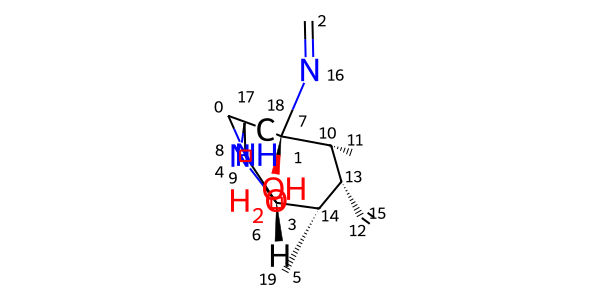

In [17]:
smi = '[H]C1=C2[C@@]3([H])OC([H])([H])[C@@]3([H])[C@@]2([H])C([H])([H])C1([H])[H]'
m, ref_m = test_ref_smi(smi, path)
m

In [18]:
viz(smi, path)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## SE(3) Transformer

### With Hydrogen
- MSE loss
- Aromatic mode

In [15]:
path = '../lightning_logs/vp_bridge_QM9Dataset_2024-05-19_01_34_10.875509/reconstructed_mols_aromatic_mode'
mols = load_mol(path)
len(mols)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11299/11299 [06:32<00:00, 28.82it/s]


11299

- Basic mode (not consider aromatic bond) 

**Prolly not completed**

In [16]:
path = '../lightning_logs/vp_bridge_QM9Dataset_2024-05-19_01_34_10.875509/reconstructed_mols'
mols = load_mol(path)
len(mols)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9864/9864 [04:38<00:00, 35.39it/s]


9864

 # Cross docked dataset

In [8]:
viz('5uwn_A_rec_3i7i_518_lig_tt_min_0', '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104/reconstructed_mols')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
viz('1bzj_A_rec_1wax_lo1_lig_tt_docked_2', '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104/reconstructed_mols')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
viz('4m7b_A_rec_5al2_o53_lig_tt_min_0', '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104/reconstructed_mols')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.